In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
# Import data
df = pd.read_csv('AB_NYC_2019.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

## Data Preprocessing & EDA

For the review information

In [ ]:
# create a feature to show the house that have no review
df['no_review'] = '0' # 0 indicates there are reviews and 1 indicates there is no review
df['no_review'][df['last_review'].isna()] = 1

<ipython-input-20-555a230796e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_review'][df['last_review'].isna()] = 1


In [ ]:
# change the last_review format to datetime
df.last_review=pd.to_datetime(df.last_review)
date_2019_12_31 = pd.to_datetime('2019-12-31')
df['last_review'] = (date_2019_12_31-df.last_review).dt.days

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,no_review
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,438.0,0.21,6,365,0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,224.0,0.38,2,355,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,1
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,179.0,4.64,1,194,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,407.0,0.10,1,0,0


Impute missing values

In [ ]:
df['last_review'] = df['last_review'].fillna(df['last_review'].max())
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['name'] = df['name'].fillna(' ')
df['host_name'] = df['host_name'].fillna(' ')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48895 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48895 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

For the name

In [ ]:
# add the variable that indicates the number of words in name
df['count_name'] = df['name'].apply(lambda x: len(x.split()))

**Remove Outliers**

In [ ]:
df["price"].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

<ipython-input-35-5ad8caab4d50>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_price, bins = 100, color = 'lightblue', fit=norm)


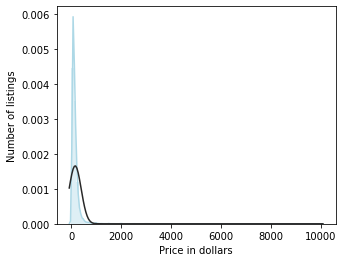

In [ ]:
# Distribution of price
from scipy.stats import norm
df_price = df["price"]
plt.figure(figsize=(5, 4))
sns.distplot(df_price, bins = 100, color = 'lightblue', fit=norm)
plt.xlabel('Price in dollars')
plt.ylabel('Number of listings')
plt.show()

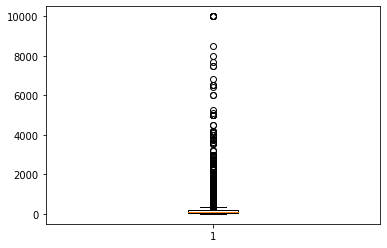

In [ ]:
# create and display a boxplot of the price variable
plt.boxplot(df['price'])
plt.show()

In [ ]:
#remove outliers for 'price'
p1 = df['price'].quantile(0.99)
p2 = df['price'].quantile(0.01)
df = df[(df['price']<p1) & (df['price']>p2)]

In [ ]:
#remove outliers for 'minimum_nights'
m1 = df['minimum_nights'].quantile(0.99)
df = df[(df['minimum_nights']<m1)]

log price

In [ ]:
df["price"] = np.log1p(df["price"])

<ipython-input-42-5ad8caab4d50>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_price, bins = 100, color = 'lightblue', fit=norm)


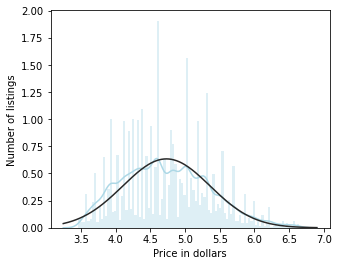

In [ ]:
# Distribution of price
from scipy.stats import norm

plt.figure(figsize=(5, 4))
sns.distplot(df_price, bins = 100, color = 'lightblue', fit=norm)
plt.xlabel('Price in dollars')
plt.ylabel('Number of listings')
plt.show()

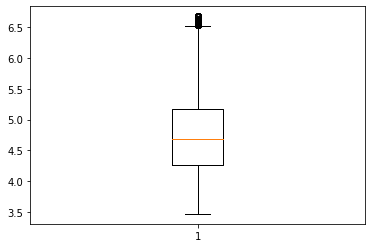

In [ ]:
# create and display a boxplot of the price variable
plt.boxplot(df['price'])
plt.show()

Exploratory data analysis

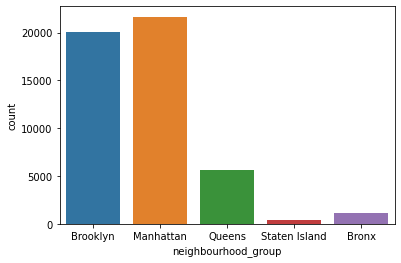

In [ ]:
# check the distribution of the houses by neighbourhood group
sns.countplot(x = df["neighbourhood_group"])
plt.show()

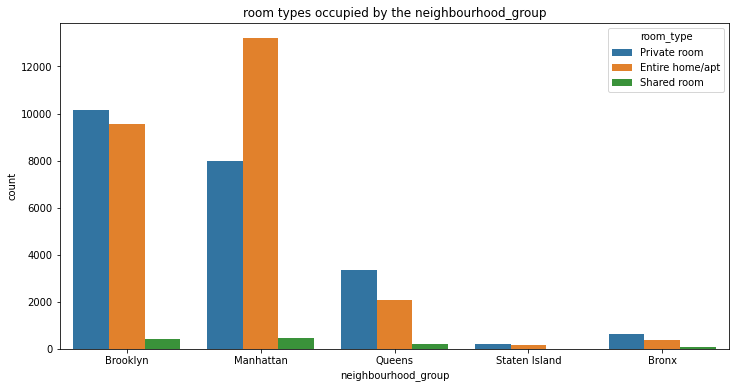

In [ ]:
# distribution of the neighborhood group by room type

plt.figure(figsize=(12,6))
sns.countplot(data = df,x="neighbourhood_group",hue="room_type")
plt.title("room types occupied by the neighbourhood_group")
plt.show()

In [ ]:
#Sum of reviews for each room type in different neighbourhood group
sum_reviews = df.pivot_table('number_of_reviews',index='neighbourhood_group',columns='room_type',aggfunc='sum')
sum_reviews

room_type,Entire home/apt,Private room,Shared room
neighbourhood_group,,,
Bronx,11627,16312,432
Brooklyn,267128,213653,5793
Manhattan,235147,209150,10272
Queens,60644,93561,2745
Staten Island,5857,5670,14


Text(0.5, 1.0, 'Sum of reviews for each room type in different neighbourhood group')

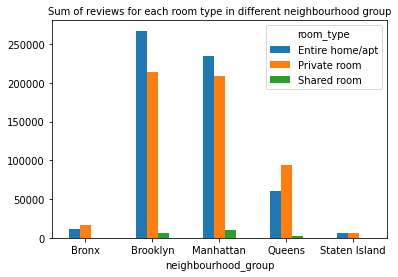

In [ ]:
sum_reviews.plot.bar(fontsize=10, rot=0)
plt.title('Sum of reviews for each room type in different neighbourhood group', fontsize=10)

In [ ]:
# Average price for each room type in different neighbourhood groups 
df_avg_price = df.groupby([df['neighbourhood_group'],df['room_type']])['price'].mean().unstack()
df_avg_price

room_type,Entire home/apt,Private room,Shared room
neighbourhood_group,,,
Bronx,127.506596,66.788344,59.800000
Brooklyn,178.327545,76.500099,50.527845
Manhattan,249.239109,116.776622,88.977083
Queens,147.050573,71.762456,69.020202
Staten Island,173.846591,62.292553,57.444444


Text(0.5, 1.0, 'Average price for each room type in different neighbourhood groups')

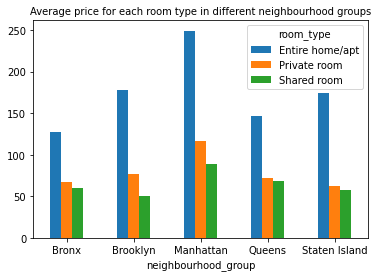

In [ ]:
df_avg_price.plot.bar(fontsize=10, rot=0)
plt.title('Average price for each room type in different neighbourhood groups', fontsize=10)

Select features

In [ ]:
allcols = list(df.columns.values)
print(allcols)

['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'no_review', 'count_name']


In [ ]:
# features to choose
num_feature = ['latitude', 'longitude','minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'no_review', 'count_name']
cat_feature = ['neighbourhood_group', 'neighbourhood', 'room_type']

selected_feature = num_feature+cat_feature

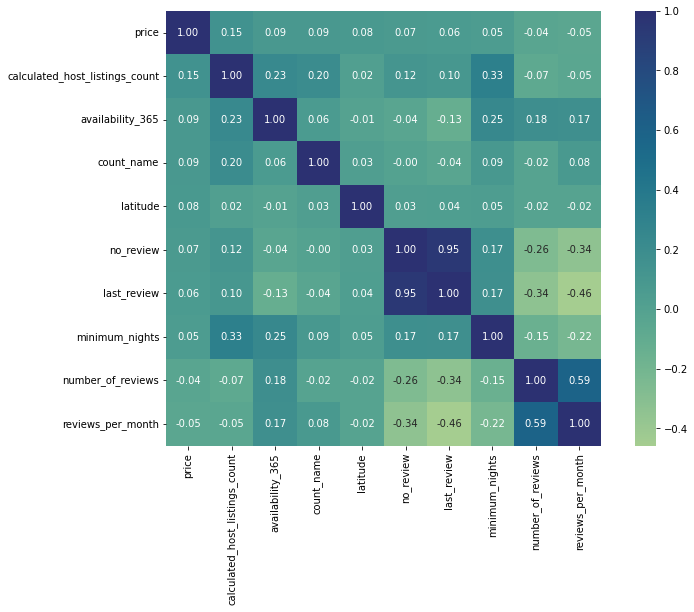

In [ ]:
# checking correlation
target_feature=['price']
selected_colomns = num_feature +cat_feature+target_feature
df_copy = df[selected_colomns].copy()
scaler = MinMaxScaler()
num=num_feature +target_feature
df_copy[num] = scaler.fit_transform(df_copy[num])
corr=df_copy.corr()
cols = corr.nlargest(10, 'price')['price'].index
corr_10=corr.loc[cols,cols]
plt.figure(figsize=(12,8))
sns.heatmap(corr_10,annot=True,square=True,fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values,cmap='crest')
plt.show()

In [ ]:
x_data = df[selected_feature]
y_data = df[['price']]

In [ ]:
# split training & test set
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(37809, 13) (9453, 13)
(37809, 1) (9453, 1)


## Create the pipeline of Ensemble model

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), cat_feature),
    ('standard_scaler', MinMaxScaler(), num_feature)])

**MODEL1: XG boost**

In [ ]:
model1 = make_pipeline(preprocessor,xgb.XGBRegressor(objective="reg:linear", random_state=40))
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

[15:29:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
r2 score: 0.644194383166557


In [ ]:
#We tried to tune hyperparameters by using GridSearchCV
from sklearn.pipeline import Pipeline

model = xgb.XGBRegressor(objective="reg:linear", random_state=40)

# Define your pipeline with GridSearchCV step
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search', GridSearchCV(model, param_grid={
                                    'n_estimators': [100, 500, 1000],
                                    'max_depth': [3, 5, 7],
                                    'learning_rate': [0.01, 0.1, 1.0]})),
])
pipeline.fit(X_train, y_train)

# Get the best parameters and score from the grid search
print("Best parameters found:", pipeline.named_steps['grid_search'].best_params_)
print("Best R-squared score:", pipeline.named_steps['grid_search'].best_score_)

[14:26:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: ../src/objective/regression_

In [ ]:
# Because the result after tuning hyperparameters is worse than the result of default parameters,so we used the default parameters
# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model1, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

[15:29:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Cross-validation R-squared scores: [0.63152045 0.64044107 0.61975184 0.6447885  0.63086109]
Mean R-squared score: 0.633
Standard deviation of R-squared scores: 0.009


**MODEL 2: Gradient Boosting**

In [ ]:
model2 = make_pipeline(preprocessor, GradientBoostingRegressor(n_estimators=500))
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 score: 0.6350535408782785


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

Cross-validation R-squared scores: [0.62631798 0.63533321 0.61425328 0.63656166 0.62996452]
Mean R-squared score: 0.628
Standard deviation of R-squared scores: 0.008


**MODEL 3: Random Forest**

In [ ]:
model3 = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=500))

model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model3, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


r2 score: 0.6433599931059055


/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

Cross-validation R-squared scores: [0.63187475 0.64024944 0.62564755 0.64147931 0.6334523 ]
Mean R-squared score: 0.635
Standard deviation of R-squared scores: 0.006


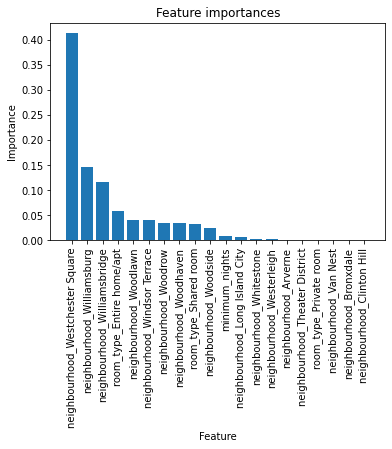

In [ ]:
importances = model3.steps[-1][1].feature_importances_


# Get the feature names from the column transformer
feature_names = []
cat_encoder = model3.named_steps['columntransformer'].named_transformers_['one-hot-encoder']
cat_encoder_feature_names = cat_encoder.get_feature_names_out(cat_feature)

feature_names = num_feature + cat_encoder_feature_names.tolist()

sorted_idx = importances.argsort()[::-1]
sorted_idx = sorted_idx[:20]
plt.bar(range(20), importances[sorted_idx])

# Set the tick positions and labels
feature_names_sorted = [feature_names[i] for i in sorted_idx]
plt.xticks(range(20),feature_names_sorted, rotation=90)

# Add axis labels and title
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")

# Show the plot
plt.show()

**MODEL 4: AdaBoost**

In [ ]:
model4 = make_pipeline(preprocessor, AdaBoostRegressor(n_estimators=800))

model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model4, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 score: 0.4661160146348591


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

Cross-validation R-squared scores: [0.50182242 0.47236798 0.48856681 0.50252574 0.49958178]
Mean R-squared score: 0.493
Standard deviation of R-squared scores: 0.011


**MODEL 5: Baggings**

In [ ]:
# use GridSearchCV individually using 'n_estimators': [10, 50, 100] and find n_estimators=50 works best
model5 = make_pipeline(preprocessor, BaggingRegressor(n_estimators=50))

model5.fit(X_train, y_train)
y_pred = model5.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model5, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


r2 score: 0.6379188239296423


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

Cross-validation R-squared scores: [0.6268324  0.63566233 0.62117849 0.63437526 0.62594019]
Mean R-squared score: 0.629
Standard deviation of R-squared scores: 0.005
